In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [86]:
df_dial = pd.read_csv('data.csv', index_col=0)

In [87]:
df_standart = pd.read_csv('standart_data.csv', index_col=0)

In [88]:
def age_groups(age):
    if age < 25:
        return 'young'
    elif 40 < age < 46:
        return 'middle'
    else:
        return 'elderly'

In [89]:
df_standart['age_group'] = df_standart['age'].apply(age_groups)
df_standart = df_standart.sample(frac=1)

In [90]:
df_int = df_dial[df_dial['informant'] == 'Interviewer']
df_last = pd.concat([df_standart, df_int])
df_last = df_last.sample(frac=1).head(1207)

In [91]:
df_opochka = df_dial[df_dial['corpus'] == 'opochka'].sample(frac=1).head(1207)
df_don = df_dial[df_dial['corpus'] == 'don_rnd'].sample(frac=1).head(1207)
df_keba = df_dial[df_dial['corpus'] == 'keba'].sample(frac=1).head(1207)

In [92]:
df_last = pd.concat([df_last, df_opochka, df_keba, df_don]).sample(frac=1)

In [93]:
df_last.to_csv('total.csv')

In [94]:
df_last = pd.read_csv('total.csv')

In [128]:
df_last['difference'] = (df_last['end']*1000 -  df_last['start']*1000)
timing = (sum(df_last['difference'])/1000)/60
print(timing)

288.73339999999996


In [14]:
!pip3 install https://download.pytorch.org/whl/cpu/torch-1.0.1-cp36-cp36m-win_amd64.whl
!pip3 install torchvision

ERROR: torch-1.0.1-cp36-cp36m-win_amd64.whl is not a supported wheel on this platform.


In [13]:
!pip install transformers

In [96]:
import librosa
import torch
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from tqdm.notebook import tqdm

In [97]:
model_name = "facebook/wav2vec2-large-xlsr-53"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name, device='cuda')
model_w2v = Wav2Vec2Model.from_pretrained(model_name)

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2Model: ['project_hid.bias', 'quantizer.weight_proj.weight', 'quantizer.weight_proj.bias', 'quantizer.codevectors', 'project_q.bias', 'project_q.weight', 'project_hid.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [98]:
files = list(df_last['filename'])

In [99]:
massivix = []
for i in tqdm(files):
    try:
        input_audio, sample_rate = librosa.load(i,  sr=16000)
        massivix.append(input_audio)
    except:
        print(i)

  0%|          | 0/4828 [00:00<?, ?it/s]

In [100]:
vectors = b.input_values

In [44]:
torch.save(vectors, 'vectors.pth')

In [45]:
vectors = torch.load('vectors.pth', map_location=torch.device('cpu'))

In [47]:
from torch.utils.data import DataLoader, Dataset

In [48]:
class VectorsDataset(Dataset):
    def __init__(self, X, paths):
        self.X = torch.tensor(X)
        self.paths = paths
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.paths[idx]

In [102]:
dataset = VectorsDataset(X=vectors, paths=files)

/var/folders/tl/xqt8rvfj2_x_0216w6nc9xyh0000gn/T/ipykernel_69134/832104874.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


In [103]:
dataloader = DataLoader(dataset, 64, True)

In [104]:
! rm -r predictions_dials

In [105]:
!mkdir predictions_dials

In [106]:
path2vec = {}
for vector, paths in tqdm(dataloader):
    predict = model_w2v(vector.to('cpu')).extract_features
    for i in range(len(predict)):
        filename = 'predictions_dials/' + paths[i].replace('.wav', '.pth').replace('/', '_')
        torch.save(predict[i], filename)
        path2vec[paths[i]] = filename
        # print(predict[i].shape)


  0%|          | 0/76 [00:00<?, ?it/s]

In [30]:
import pickle

with open('data_standart.pickle', 'wb') as f:
     pickle.dump(path2vec, f)

with open('data_standart.pickle', 'rb') as f:
     path2vec = pickle.load(f)

In [107]:
items = path2vec.items()

In [108]:
X = []
Y = []
for item in tqdm(items):
    vector = torch.load(item[1]).detach().tolist()
    targets = df_last[df_last['filename'] == item[0]]
    target = targets['corpus'].to_list()[0]
    X.append(sum(np.array(vector)))
    Y.append(target)

  0%|          | 0/4828 [00:00<?, ?it/s]

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [112]:
def accuracy(dct, y_test, y_pred):
    total = len(y_test)
    count = 0
    for i in range(len(y_test)):
        dct[y_test[i]][y_pred[i]] += 1

    return dct

In [117]:
dct = {
    'don_rnd': {
        'don_rnd': 0,
        'keba': 0,
        'opochka': 0,
        'standart': 0
    },
    'keba': {
        'don_rnd': 0,
        'keba': 0,
        'opochka': 0,
        'standart': 0
    },
    'opochka': {
        'don_rnd': 0,
        'keba': 0,
        'opochka': 0,
        'standart': 0
    },
    'standart': {
        'don_rnd': 0,
        'keba': 0,
        'opochka': 0,
        'standart': 0
    }
}

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install cmake

In [ ]:
!pip install catboost==1.1.1

In [114]:
from catboost import CatBoostClassifier

train_data = X_train
train_labels = y_train

model = CatBoostClassifier(iterations=200)
model.fit(train_data, train_labels)

Learning rate set to 0.327303
0:	learn: 1.1629381	total: 249ms	remaining: 49.6s
1:	learn: 1.0162435	total: 397ms	remaining: 39.3s
2:	learn: 0.9257551	total: 571ms	remaining: 37.5s
3:	learn: 0.8627892	total: 737ms	remaining: 36.1s
4:	learn: 0.8195276	total: 910ms	remaining: 35.5s
5:	learn: 0.7661415	total: 1.06s	remaining: 34.4s
6:	learn: 0.7376751	total: 1.25s	remaining: 34.3s
7:	learn: 0.7076638	total: 1.41s	remaining: 33.8s
8:	learn: 0.6793320	total: 1.58s	remaining: 33.5s
9:	learn: 0.6600969	total: 1.73s	remaining: 32.9s
10:	learn: 0.6364364	total: 1.9s	remaining: 32.7s
11:	learn: 0.6159285	total: 2.19s	remaining: 34.4s
12:	learn: 0.6026807	total: 2.36s	remaining: 34s
13:	learn: 0.5861103	total: 2.55s	remaining: 33.8s
14:	learn: 0.5737912	total: 2.7s	remaining: 33.3s
15:	learn: 0.5578219	total: 2.88s	remaining: 33.1s
16:	learn: 0.5469504	total: 3.03s	remaining: 32.7s
17:	learn: 0.5372820	total: 3.21s	remaining: 32.5s
18:	learn: 0.5280510	total: 3.38s	remaining: 32.2s
19:	learn: 0.51

161:	learn: 0.1453331	total: 35.7s	remaining: 8.36s
162:	learn: 0.1448946	total: 35.9s	remaining: 8.15s
163:	learn: 0.1436480	total: 36.3s	remaining: 7.96s
164:	learn: 0.1426074	total: 36.5s	remaining: 7.75s
165:	learn: 0.1421263	total: 36.8s	remaining: 7.53s
166:	learn: 0.1412562	total: 37s	remaining: 7.32s
167:	learn: 0.1406769	total: 37.3s	remaining: 7.1s
168:	learn: 0.1402166	total: 37.5s	remaining: 6.88s
169:	learn: 0.1392394	total: 37.7s	remaining: 6.66s
170:	learn: 0.1386281	total: 38s	remaining: 6.44s
171:	learn: 0.1376369	total: 38.2s	remaining: 6.22s
172:	learn: 0.1368497	total: 38.4s	remaining: 5.99s
173:	learn: 0.1359571	total: 38.6s	remaining: 5.77s
174:	learn: 0.1353248	total: 38.9s	remaining: 5.56s
175:	learn: 0.1347461	total: 39.1s	remaining: 5.33s
176:	learn: 0.1338628	total: 39.4s	remaining: 5.11s
177:	learn: 0.1328811	total: 39.7s	remaining: 4.9s
178:	learn: 0.1321145	total: 40s	remaining: 4.69s
179:	learn: 0.1312488	total: 40.3s	remaining: 4.48s
180:	learn: 0.130595

In [63]:
import itertools

In [115]:
y_pred = model.predict(X_test)

In [118]:
accuracy(dct, y_test, list(itertools.chain.from_iterable(y_pred.tolist())))

{'don_rnd': {'don_rnd': 356, 'keba': 30, 'opochka': 6, 'standart': 36},
 'keba': {'don_rnd': 15, 'keba': 343, 'opochka': 6, 'standart': 22},
 'opochka': {'don_rnd': 3, 'keba': 15, 'opochka': 342, 'standart': 25},
 'standart': {'don_rnd': 53, 'keba': 69, 'opochka': 50, 'standart': 223}}

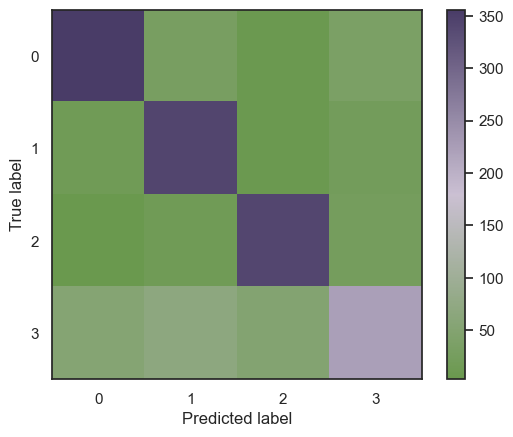

In [127]:
import matplotlib.pyplot as plt
import numpy
import matplotlib.colors
from sklearn import metrics

sns.set_theme(style="white")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#6a994e","#cbc0d3","#493c67"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot(include_values=False, cmap=cmap)
plt.show()

In [83]:
print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'), sep='\n')

0.4839924670433145
0.48192850031195744


In [51]:
# X, y = make_classification(n_samples=100, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
#                                                      random_state=1)
clf = MLPClassifier(hidden_layer_sizes=(512,), random_state=1, max_iter=300, verbose=True).fit(X_train, y_train)

clf.predict(X_test)
clf.score(X_test, y_test)


Iteration 1, loss = 3.86548175
Iteration 2, loss = 1.35983443
Iteration 3, loss = 0.76254491
Iteration 4, loss = 0.52548221
Iteration 5, loss = 0.35343981
Iteration 6, loss = 0.25753556
Iteration 7, loss = 0.21681868
Iteration 8, loss = 0.22818283
Iteration 9, loss = 0.16951741
Iteration 10, loss = 0.15533807
Iteration 11, loss = 0.16095410
Iteration 12, loss = 0.12690658
Iteration 13, loss = 0.09212249
Iteration 14, loss = 0.06702060
Iteration 15, loss = 0.06929310
Iteration 16, loss = 0.07162314
Iteration 17, loss = 0.08780091
Iteration 18, loss = 0.08531902
Iteration 19, loss = 0.05005745
Iteration 20, loss = 0.04934247
Iteration 21, loss = 0.04829331
Iteration 22, loss = 0.04376672
Iteration 23, loss = 0.06365679
Iteration 24, loss = 0.04540372
Iteration 25, loss = 0.06810872
Iteration 26, loss = 0.15736194
Iteration 27, loss = 0.29890856
Iteration 28, loss = 0.15587653
Iteration 29, loss = 0.08795957
Iteration 30, loss = 0.04956995
Iteration 31, loss = 0.02698725
Iteration 32, los

0.7848180677540778

## F-t

In [30]:
model_name_ft = "jonatasgrosman/wav2vec2-large-xlsr-53-russian"
feature_extractor_ft = Wav2Vec2FeatureExtractor.from_pretrained(model_name_ft, device='cuda')
model_ft = Wav2Vec2Model.from_pretrained(model_name_ft)

Some weights of the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-russian were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
vectors_ft = feature_extractor_ft(massivix, return_tensors="pt", sampling_rate=sample_rate, padding='max_length', 
                    max_length=2620, truncation=True).input_values

In [64]:
torch.save(vectors_ft, 'vectors_ft.pth')

In [66]:
vectors_ft = torch.load('vectors_ft.pth', map_location=torch.device('cpu'))

dataset_ft = VectorsDataset(X=vectors_ft, paths=files)
dataloader = DataLoader(dataset_ft, 64, True)

/var/folders/tl/xqt8rvfj2_x_0216w6nc9xyh0000gn/T/ipykernel_42948/832104874.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


In [67]:
!mkdir predictions_dials_ft

In [68]:
path2vec = {}
for vector_ent, paths in tqdm(dataloader):
    predict = model_ft(vector_ent.to('cpu')).extract_features
    for i in range(len(predict)):
        filename = 'predictions_dials_ft/' + paths[i].replace('.wav', '.pth').replace('/', '_')
        torch.save(predict[i], filename)
        path2vec[paths[i]] = filename
        # print(predict[i].shape)


  0%|          | 0/76 [00:00<?, ?it/s]

In [70]:
import pickle

with open('data_ft.pickle', 'wb') as f:
     pickle.dump(path2vec, f)

with open('data_ft.pickle', 'rb') as f:
     path2vec = pickle.load(f)

In [71]:
items_ft = path2vec.items()

In [74]:
X_ft = []
Y_ft = []
for item in tqdm(items_ft):
    vector = torch.load(item[1]).detach().tolist()
    targets = df_last[df_last['filename'] == item[0]]
    target = targets['corpus'].to_list()[0]
    X_ft.append(sum(np.array(vector)))
    Y_ft.append(target)

  0%|          | 0/4828 [00:00<?, ?it/s]

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_ft, Y_ft, test_size=0.33, random_state=42)

train_data = X_train
train_labels = y_train

model = CatBoostClassifier(iterations=200)
model.fit(train_data, train_labels)

y_pred = model.predict(X_test)

Learning rate set to 0.327303
0:	learn: 1.1775842	total: 293ms	remaining: 58.2s
1:	learn: 1.0194866	total: 509ms	remaining: 50.4s
2:	learn: 0.9291852	total: 735ms	remaining: 48.3s
3:	learn: 0.8601267	total: 951ms	remaining: 46.6s
4:	learn: 0.8159920	total: 1.18s	remaining: 45.9s
5:	learn: 0.7794938	total: 1.39s	remaining: 45.1s
6:	learn: 0.7480796	total: 1.62s	remaining: 44.7s
7:	learn: 0.7148119	total: 1.85s	remaining: 44.5s
8:	learn: 0.6821675	total: 2.07s	remaining: 44s
9:	learn: 0.6574758	total: 2.31s	remaining: 43.9s
10:	learn: 0.6379649	total: 2.55s	remaining: 43.8s
11:	learn: 0.6186636	total: 2.78s	remaining: 43.5s
12:	learn: 0.6089065	total: 3.01s	remaining: 43.3s
13:	learn: 0.5952071	total: 3.27s	remaining: 43.5s
14:	learn: 0.5838367	total: 3.49s	remaining: 43.1s
15:	learn: 0.5734456	total: 3.72s	remaining: 42.8s
16:	learn: 0.5613961	total: 3.94s	remaining: 42.4s
17:	learn: 0.5523525	total: 4.17s	remaining: 42.2s
18:	learn: 0.5394470	total: 4.42s	remaining: 42.1s
19:	learn: 0.

161:	learn: 0.1436111	total: 42.5s	remaining: 9.97s
162:	learn: 0.1425330	total: 42.8s	remaining: 9.71s
163:	learn: 0.1415540	total: 43s	remaining: 9.45s
164:	learn: 0.1400339	total: 43.4s	remaining: 9.2s
165:	learn: 0.1391198	total: 43.7s	remaining: 8.95s
166:	learn: 0.1378101	total: 44s	remaining: 8.69s
167:	learn: 0.1370870	total: 44.3s	remaining: 8.44s
168:	learn: 0.1365213	total: 44.6s	remaining: 8.18s
169:	learn: 0.1359897	total: 44.9s	remaining: 7.92s
170:	learn: 0.1347603	total: 45.2s	remaining: 7.67s
171:	learn: 0.1333576	total: 45.5s	remaining: 7.41s
172:	learn: 0.1325524	total: 45.8s	remaining: 7.14s
173:	learn: 0.1319431	total: 46s	remaining: 6.88s
174:	learn: 0.1314671	total: 46.3s	remaining: 6.61s
175:	learn: 0.1301178	total: 46.6s	remaining: 6.35s
176:	learn: 0.1295503	total: 46.8s	remaining: 6.08s
177:	learn: 0.1282056	total: 47.1s	remaining: 5.82s
178:	learn: 0.1270749	total: 47.4s	remaining: 5.55s
179:	learn: 0.1264626	total: 47.6s	remaining: 5.29s
180:	learn: 0.12573

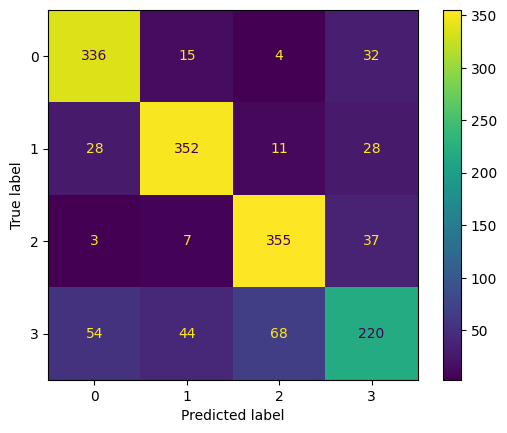

In [81]:
actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [83]:
print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'), sep='\n')

0.7923462986198243
0.7859773685441035


In [84]:
clf = MLPClassifier(hidden_layer_sizes=(512,), random_state=1, max_iter=300, verbose=True).fit(X_train, y_train)

clf.predict(X_test)
clf.score(X_test, y_test)

Iteration 1, loss = 4.26103383
Iteration 2, loss = 2.04721633
Iteration 3, loss = 0.91192307
Iteration 4, loss = 0.56818309
Iteration 5, loss = 0.37767386
Iteration 6, loss = 0.32194133
Iteration 7, loss = 0.26162130
Iteration 8, loss = 0.25842846
Iteration 9, loss = 0.21046669
Iteration 10, loss = 0.16122136
Iteration 11, loss = 0.17060107
Iteration 12, loss = 0.13010732
Iteration 13, loss = 0.09383668
Iteration 14, loss = 0.09790478
Iteration 15, loss = 0.10168681
Iteration 16, loss = 0.06643331
Iteration 17, loss = 0.07075209
Iteration 18, loss = 0.06438144
Iteration 19, loss = 0.05249991
Iteration 20, loss = 0.04668029
Iteration 21, loss = 0.04954629
Iteration 22, loss = 0.06636389
Iteration 23, loss = 0.04848449
Iteration 24, loss = 0.03609030
Iteration 25, loss = 0.02984716
Iteration 26, loss = 0.03908560
Iteration 27, loss = 0.05458771
Iteration 28, loss = 0.05456361
Iteration 29, loss = 0.05003900
Iteration 30, loss = 0.02857967
Iteration 31, loss = 0.02518519
Iteration 32, los

0.7772898368883312

## Whisper

In [4]:
import whisper

model = whisper.load_model("base").to('cuda')

/opt/conda/lib/python3.10/site-packages/whisper/timing.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):
100%|███████████████████████████████████████| 139M/139M [00:04<00:00, 35.9MiB/s]


In [5]:
!mkdir whisper_predictions_dials

In [27]:
path2vec_whisper = {}
for file in tqdm(files):
    try:
        audio = whisper.load_audio(file)
        audio = whisper.pad_or_trim(audio)
        mel = whisper.log_mel_spectrogram(audio).to('cuda')
        options = whisper.DecodingOptions(fp16=False)
        result = whisper.decode(model, mel, options)
        
        filename = 'whisper_predictions_dials/' + file.replace('.wav', '.pth').replace('/', '_')
        torch.save(result.audio_features, filename)
        path2vec_whisper[file] = filename
    except:
        print('No such file')

  0%|          | 0/4828 [00:00<?, ?it/s]

No such file


In [29]:
X_whd = []
Y_whd = []
for item in tqdm(path2vec_whisper.items()):
    vector = torch.load(item[1]).detach().tolist()
    targets = df_last[df_last['filename'] == item[0]]
    target = targets['corpus'].to_list()[0]
    X_whd.append(sum(np.array(vector)))
    Y_whd.append(target)

  0%|          | 0/4827 [00:00<?, ?it/s]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_whd, Y_whd, test_size=0.33, random_state=42)

train_data = X_train
train_labels = y_train

model = CatBoostClassifier(iterations=200)
model.fit(train_data, train_labels)

y_pred = model.predict(X_test)

Learning rate set to 0.327303
0:	learn: 1.1021081	total: 127ms	remaining: 25.2s
1:	learn: 0.9604705	total: 182ms	remaining: 18s
2:	learn: 0.8706982	total: 241ms	remaining: 15.8s
3:	learn: 0.8111899	total: 300ms	remaining: 14.7s
4:	learn: 0.7561574	total: 358ms	remaining: 14s
5:	learn: 0.7199373	total: 416ms	remaining: 13.5s
6:	learn: 0.6780176	total: 474ms	remaining: 13.1s
7:	learn: 0.6473159	total: 541ms	remaining: 13s
8:	learn: 0.6253043	total: 602ms	remaining: 12.8s
9:	learn: 0.5962608	total: 655ms	remaining: 12.4s
10:	learn: 0.5727451	total: 712ms	remaining: 12.2s
11:	learn: 0.5531997	total: 768ms	remaining: 12s
12:	learn: 0.5386488	total: 827ms	remaining: 11.9s
13:	learn: 0.5288938	total: 880ms	remaining: 11.7s
14:	learn: 0.5179633	total: 937ms	remaining: 11.6s
15:	learn: 0.5024330	total: 995ms	remaining: 11.4s
16:	learn: 0.4914934	total: 1.05s	remaining: 11.3s
17:	learn: 0.4781673	total: 1.11s	remaining: 11.3s
18:	learn: 0.4727188	total: 1.17s	remaining: 11.1s
19:	learn: 0.462514

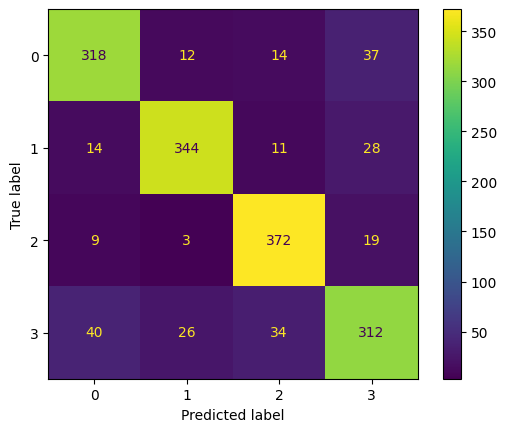

0.8449466415568111
0.8447011560922001


In [43]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()
print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'), sep='\n')

In [44]:
clf_whd = MLPClassifier(hidden_layer_sizes=(512,), random_state=1, max_iter=300, verbose=True).fit(X_train, y_train)

clf_whd.predict(X_test)
clf_whd.score(X_test, y_test)

Iteration 1, loss = 23.53813683
Iteration 2, loss = 16.40984657
Iteration 3, loss = 10.33994791
Iteration 4, loss = 8.09689664
Iteration 5, loss = 6.68980983
Iteration 6, loss = 6.26731479
Iteration 7, loss = 6.92162084
Iteration 8, loss = 6.86529412
Iteration 9, loss = 6.36470043
Iteration 10, loss = 5.70301310
Iteration 11, loss = 5.54898045
Iteration 12, loss = 5.11022532
Iteration 13, loss = 5.98775663
Iteration 14, loss = 5.77806146
Iteration 15, loss = 5.24301139
Iteration 16, loss = 5.05516152
Iteration 17, loss = 5.30957564
Iteration 18, loss = 4.05004636
Iteration 19, loss = 3.50514340
Iteration 20, loss = 5.22059826
Iteration 21, loss = 4.81640152
Iteration 22, loss = 10.00784296
Iteration 23, loss = 7.11647017
Iteration 24, loss = 4.96708514
Iteration 25, loss = 4.58173698
Iteration 26, loss = 3.93361238
Iteration 27, loss = 3.62814492
Iteration 28, loss = 4.67317704
Iteration 29, loss = 4.59111162
Iteration 30, loss = 4.38450867
Training loss did not improve more than tol=0

0.8725674827369743

## Layers

In [17]:
o = model_w2v(vectors, output_hidden_states=True)

In [20]:
ys = df_last['corpus'].to_list()

In [23]:
def for_each(tensor, ys):
    X_train, X_test, y_train, y_test = train_test_split(tensor, ys, test_size=0.33, random_state=42)

    train_data = X_train
    train_labels = y_train

    model = CatBoostClassifier(iterations=200, task_type="GPU",
                           devices='0', verbose=False)
    model.fit(train_data, train_labels)

    y_pred = model.predict(X_test)
    f_score = f1_score(y_test, y_pred, average='macro')
    print(f_score)
    return f_score

In [24]:
results = {}
layers = o['hidden_states']
for i in tqdm(range(len(layers))):
    print(f'LAYER: {i+1}')
    reshaped = torch.reshape(layers[i], (1228, 7*1024)).tolist()
    resultic = for_each(reshaped, ys)
    results[i+1] = resultic
    print(f'Result on layer {i+1}: {resultic}')
    print('-'*10)

  0%|          | 0/25 [00:00<?, ?it/s]

LAYER: 1
0.7310413737996224
Result on layer 1: 0.7310413737996224
----------
LAYER: 2
0.7252591440123041
Result on layer 2: 0.7252591440123041
----------
LAYER: 3
0.7084645373300836
Result on layer 3: 0.7084645373300836
----------
LAYER: 4
0.6954856174816803
Result on layer 4: 0.6954856174816803
----------
LAYER: 5
0.7204845779217296
Result on layer 5: 0.7204845779217296
----------
LAYER: 6
0.691331170736205
Result on layer 6: 0.691331170736205
----------
LAYER: 7
0.6892166904292183
Result on layer 7: 0.6892166904292183
----------
LAYER: 8
0.653625220264392
Result on layer 8: 0.653625220264392
----------
LAYER: 9
0.6863528727971233
Result on layer 9: 0.6863528727971233
----------
LAYER: 10
0.6501539715994165
Result on layer 10: 0.6501539715994165
----------
LAYER: 11
0.6612683132139305
Result on layer 11: 0.6612683132139305
----------
LAYER: 12
0.6290134136219768
Result on layer 12: 0.6290134136219768
----------
LAYER: 13
0.6449607167266236
Result on layer 13: 0.6449607167266236
------

In [28]:
results

{1: 0.7310413737996224,
 2: 0.7252591440123041,
 3: 0.7084645373300836,
 4: 0.6954856174816803,
 5: 0.7204845779217296,
 6: 0.691331170736205,
 7: 0.6892166904292183,
 8: 0.653625220264392,
 9: 0.6863528727971233,
 10: 0.6501539715994165,
 11: 0.6612683132139305,
 12: 0.6290134136219768,
 13: 0.6449607167266236,
 14: 0.6372013893016077,
 15: 0.6339760541897919,
 16: 0.654259324102158,
 17: 0.6463188930269599,
 18: 0.6534824548599878,
 19: 0.645598666043564,
 20: 0.6802289252338167,
 21: 0.6786609001949239,
 22: 0.6867477838041556,
 23: 0.6094180249502945,
 24: 0.60633056279608,
 25: 0.6560821898884268}

In [32]:
o_ft = model_ft(vectors_ft, output_hidden_states=True)

In [33]:
results = {}
layers = o_ft['hidden_states']
for i in tqdm(range(len(layers))):
    print(f'LAYER: {i+1}')
    reshaped = torch.reshape(layers[i], (1228, 7*1024)).tolist()
    resultic = for_each(reshaped, ys)
    results[i+1] = resultic
    print(f'Result on layer {i+1}: {resultic}')
    print('-'*10)

  0%|          | 0/25 [00:00<?, ?it/s]

LAYER: 1
0.7404827747454307
Result on layer 1: 0.7404827747454307
----------
LAYER: 2
0.7273356407609679
Result on layer 2: 0.7273356407609679
----------
LAYER: 3
0.7135129409463941
Result on layer 3: 0.7135129409463941
----------
LAYER: 4
0.6796781119766346
Result on layer 4: 0.6796781119766346
----------
LAYER: 5
0.7003028329148704
Result on layer 5: 0.7003028329148704
----------
LAYER: 6
0.6878255338996329
Result on layer 6: 0.6878255338996329
----------
LAYER: 7
0.6834454390574517
Result on layer 7: 0.6834454390574517
----------
LAYER: 8
0.6755773754056418
Result on layer 8: 0.6755773754056418
----------
LAYER: 9
0.6535704690272235
Result on layer 9: 0.6535704690272235
----------
LAYER: 10
0.6273594664899013
Result on layer 10: 0.6273594664899013
----------
LAYER: 11
0.6306182740200947
Result on layer 11: 0.6306182740200947
----------
LAYER: 12
0.6281262722172316
Result on layer 12: 0.6281262722172316
----------
LAYER: 13
0.6203109124161755
Result on layer 13: 0.6203109124161755
--

In [34]:
results

{1: 0.7404827747454307,
 2: 0.7273356407609679,
 3: 0.7135129409463941,
 4: 0.6796781119766346,
 5: 0.7003028329148704,
 6: 0.6878255338996329,
 7: 0.6834454390574517,
 8: 0.6755773754056418,
 9: 0.6535704690272235,
 10: 0.6273594664899013,
 11: 0.6306182740200947,
 12: 0.6281262722172316,
 13: 0.6203109124161755,
 14: 0.6234920233275496,
 15: 0.6342084464713491,
 16: 0.6202647938567977,
 17: 0.6000363608421104,
 18: 0.6301106737111088,
 19: 0.6257562138919239,
 20: 0.5705374895130864,
 21: 0.5594917012063675,
 22: 0.5601006879822672,
 23: 0.5478886451806344,
 24: 0.5454340246912044,
 25: 0.5409260184918929}